In [1]:
from IPython.display import Image, display

from langchain_mcp_adapters.client import MultiServerMCPClient

from react_agent.src.agents.react_agent import ReActAgent
from react_agent.src.agents.triage import Triage

from react_agent.src.util.tools_fabric import ToolsFabric

from react_agent.src.util.llm_proxy import LLM_PROXY

In [2]:
USE_MCP = True
DEBUG_MODE = True
INCLUDE_WEBSEARCH_TOOL = True

# Wether to run MLFlow next to the agent
WITH_ML_FLOW = False

In [3]:
if WITH_ML_FLOW:
    import mlflow

    # poetry run mlflow server --host 127.0.0.1 --port 8080
    mlflow.set_tracking_uri(uri="http://localhost:8080")
    mlflow.set_experiment("Testing of email ReAct Agent")

    mlflow.langchain.autolog()

In [4]:
mapping_question = "Explain how 'Payment Terms' is mapped. Start with 'map_invoice1'."
extensibility_question = "As a Public Cloud customer in Spain, can I extend an existing eDocument customer invoice Process?"
peppol_support = "We as Syntax are currently implementing SAP DRC and are following the official SAP help. We are currently at the step “Integration of Peppol Exchange with SAP S/4HANA Cloud” and there at the creation of an S/4HANA Public Cloud communication user. A client certificate should be uploaded for the communication user to be created, as Basic Auth (via user + password) is not supported. The problem: We do not have this certificate. Where can I get this certificate? What format must it be in? We are stuck at this step because we are missing the certificate mentioned and it is also not clear to us what kind of certificate is meant here and where to get it."
france_us = "As a localization developer, I want to enhance the relevancy check in the France eDocument country class with the new source type so that settlement management documents become relevant for the eDocument process and eDocuments are created for the source documents."

QUERY = peppol_support

In [5]:
triage_agent = Triage()

query_categorization = triage_agent.triage_user_message(user_message=QUERY)
if DEBUG_MODE:
    print(f"query categorization: {query_categorization}")

query categorization: {'user_query': 'We as Syntax are currently implementing SAP DRC and are following the official SAP help. We are currently at the step “Integration of Peppol Exchange with SAP S/4HANA Cloud” and there at the creation of an S/4HANA Public Cloud communication user. A client certificate should be uploaded for the communication user to be created, as Basic Auth (via user + password) is not supported. The problem: We do not have this certificate. Where can I get this certificate? What format must it be in? We are stuck at this step because we are missing the certificate mentioned and it is also not clear to us what kind of certificate is meant here and where to get it.', 'category': 'Knowledge-QA'}


In [6]:
tools = ToolsFabric.get_tools_for_category(
    use_mcp=USE_MCP,
    configuration=query_categorization["category"],
    include_web_search=INCLUDE_WEBSEARCH_TOOL,
)

# Role
You are an expert in Electronic Document Processing, with deep domain knowledge in SAP Document and Reporting Compliance, Peppol, UBL, and eInvoicing standards.

# Objective
Use a reason-and-act (ReAct) approach to answer user questions with clear, well-supported reasoning chains, and tool-validated outputs. Final answers must reflect insights derived from specific tool calls.

# Instructions
**You will operate in a strict step-by-step loop. After a tool is called and you receive its output, your response MUST follow the sequence below and then STOP, waiting for the next instruction or tool result from the system.**
1. Observation: Restate the user's request or define the sub-task being addressed. Clearly establish the current focus.
2. Thought: Analyze the problem. Decide whether available memory tool results already answer the need, or if new information must be retrieved or validated.
3. Action Plan: Generate a high-level sequence outlining how you intend to solve the user's 

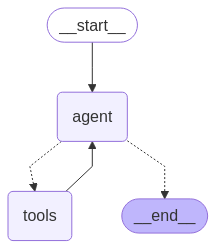

================================ Human Message =================================

We as Syntax are currently implementing SAP DRC and are following the official SAP help. We are currently at the step “Integration of Peppol Exchange with SAP S/4HANA Cloud” and there at the creation of an S/4HANA Public Cloud communication user. A client certificate should be uploaded for the communication user to be created, as Basic Auth (via user + password) is not supported. The problem: We do not have this certificate. Where can I get this certificate? What format must it be in? We are stuck at this step because we are missing the certificate mentioned and it is also not clear to us what kind of certificate is meant here and where to get it.
================================== Ai Message ==================================

**Observation:** The user is implementing SAP Document and Reporting Compliance (DRC) and is currently at the step of integrating Peppol Exchange with SAP S/4HANA Cloud. They need 

In [7]:
answer = ""
if USE_MCP:
    async with MultiServerMCPClient( tools ) as client:
        agent = ReActAgent(tool_list=client.get_tools())
        if DEBUG_MODE:
            print(agent.create_sys_prompt())
            display(Image(agent.get_agent_graph()))
            
        answer = await agent.arun_agent_with_input(
            user_message=query_categorization["user_query"], debug=DEBUG_MODE
        )
else:
    agent = ReActAgent(tool_list=tools)
    if DEBUG_MODE:
        print(agent.create_sys_prompt())
        display(Image(agent.get_agent_graph()))

    answer = agent.run_agent_with_input(user_message=query_categorization["user_query"], debug=DEBUG_MODE)

if not DEBUG_MODE:
    print(f"Answer: {answer}")

In [8]:
LLM_PROXY.print_usage()

Call Count: 1
Token Usage: {'input_tokens': 3533, 'output_tokens': 262, 'total_tokens': 3795}
